In [1]:
!pip install thop
!pip install einops
!pip install timm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from thop import profile
from einops import rearrange
from sklearn.metrics import accuracy_score, average_precision_score
from einops.layers.torch import Rearrange, Reduce
from timm.models.layers import trunc_normal_, DropPath

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class WMSA(nn.Module):
    """ Self-attention module in Swin Transformer
    """

    def __init__(self, input_dim, output_dim, head_dim, window_size, type):
        super(WMSA, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.head_dim = head_dim
        self.scale = self.head_dim ** -0.5
        self.n_heads = input_dim//head_dim
        self.window_size = window_size
        self.type=type
        self.embedding_layer = nn.Linear(self.input_dim, 3*self.input_dim, bias=True)

        #todo recover
        # self.relative_position_params = nn.Parameter(torch.zeros(self.n_heads, 2 * window_size - 1, 2 * window_size -1))
        self.relative_position_params = nn.Parameter(torch.zeros((2 * window_size - 1)*(2 * window_size -1), self.n_heads))

        self.linear = nn.Linear(self.input_dim, self.output_dim)

        trunc_normal_(self.relative_position_params, std=.02)
        self.relative_position_params = torch.nn.Parameter(self.relative_position_params.view(2*window_size-1, 2*window_size-1, self.n_heads).transpose(1,2).transpose(0,1))

    def generate_mask(self, w, p, shift):
        """ generating the mask of SW-MSA
        Args:
            shift: shift parameters in CyclicShift.
        Returns:
            attn_mask: should be (1 1 w p p),
        """
        # supporting sqaure.
        attn_mask = torch.zeros(w, w, p, p, p, p, dtype=torch.bool, device=self.relative_position_params.device)
        if self.type == 'W':
            return attn_mask

        s = p - shift
        attn_mask[-1, :, :s, :, s:, :] = True
        attn_mask[-1, :, s:, :, :s, :] = True
        attn_mask[:, -1, :, :s, :, s:] = True
        attn_mask[:, -1, :, s:, :, :s] = True
        attn_mask = rearrange(attn_mask, 'w1 w2 p1 p2 p3 p4 -> 1 1 (w1 w2) (p1 p2) (p3 p4)')
        return attn_mask

    def forward(self, x):
        """ Forward pass of Window Multi-head Self-attention module.
        Args:
            x: input tensor with shape of [b h w c];
            attn_mask: attention mask, fill -inf where the value is True;
        Returns:
            output: tensor shape [b h w c]
        """
        if self.type!='W': x = torch.roll(x, shifts=(-(self.window_size//2), -(self.window_size//2)), dims=(1,2))
        x = rearrange(x, 'b (w1 p1) (w2 p2) c -> b w1 w2 p1 p2 c', p1=self.window_size, p2=self.window_size)
        h_windows = x.size(1)
        w_windows = x.size(2)
        # sqaure validation
        assert h_windows == w_windows

        x = rearrange(x, 'b w1 w2 p1 p2 c -> b (w1 w2) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        qkv = self.embedding_layer(x)
        q, k, v = rearrange(qkv, 'b nw np (threeh c) -> threeh b nw np c', c=self.head_dim).chunk(3, dim=0)
        sim = torch.einsum('hbwpc,hbwqc->hbwpq', q, k) * self.scale
        # Adding learnable relative embedding
        sim = sim + rearrange(self.relative_embedding(), 'h p q -> h 1 1 p q')
        # Using Attn Mask to distinguish different subwindows.
        if self.type != 'W':
            attn_mask = self.generate_mask(h_windows, self.window_size, shift=self.window_size//2)
            sim = sim.masked_fill_(attn_mask, float("-inf"))

        probs = nn.functional.softmax(sim, dim=-1)
        output = torch.einsum('hbwij,hbwjc->hbwic', probs, v)
        output = rearrange(output, 'h b w p c -> b w p (h c)')
        output = self.linear(output)
        output = rearrange(output, 'b (w1 w2) (p1 p2) c -> b (w1 p1) (w2 p2) c', w1=h_windows, p1=self.window_size)

        if self.type!='W': output = torch.roll(output, shifts=(self.window_size//2, self.window_size//2), dims=(1,2))
        return output

    def relative_embedding(self):
        cord = torch.tensor(np.array([[i, j] for i in range(self.window_size) for j in range(self.window_size)]))
        relation = cord[:, None, :] - cord[None, :, :] + self.window_size -1
        # negative is allowed
        return self.relative_position_params[:, relation[:,:,0], relation[:,:,1]]

In [5]:
class Block(nn.Module):
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer Block
        """
        super(Block, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        assert type in ['W', 'SW']
        self.type = type
        if input_resolution <= window_size:
            self.type = 'W'

        print("Block Initial Type: {}, drop_path_rate:{:.6f}".format(self.type, drop_path))
        self.ln1 = nn.LayerNorm(input_dim)
        self.msa = WMSA(input_dim, input_dim, head_dim, window_size, self.type)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.ln2 = nn.LayerNorm(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 4 * input_dim),
            nn.GELU(),
            nn.Linear(4 * input_dim, output_dim),
        )

    def forward(self, x):
        x = x + self.drop_path(self.msa(self.ln1(x)))
        x = x + self.drop_path(self.mlp(self.ln2(x)))
        return x

In [6]:
class SwinTransformer(nn.Module):
    """ Implementation of Swin Transformer https://arxiv.org/abs/2103.14030
    In this Implementation, the standard shape of data is (b h w c), which is a similar protocal as cnn.
    """
    #todo make layers using configs
    def __init__(self, num_classes, config=[2,2,6,2], dim=96, drop_path_rate=0.2, input_resolution=224):
        super(SwinTransformer, self).__init__()
        self.config = config
        self.dim = dim
        self.head_dim = 32
        self.window_size = 7
        # self.patch_partition = Rearrange('b c (h1 sub_h) (w1 sub_w) -> b h1 w1 (c sub_h sub_w)', sub_h=4, sub_w=4)

        # drop path rate for each layer
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(config))]

        begin = 0
        self.stage1 = [nn.Conv2d(3, dim, kernel_size=4, stride=4),
                       Rearrange('b c h w -> b h w c'),
                       nn.LayerNorm(dim),] + \
                      [Block(dim, dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//4)
                      for i in range(config[0])]
        begin += config[0]
        self.stage2 = [Rearrange('b (h neih) (w neiw) c -> b h w (neiw neih c)', neih=2, neiw=2),
                       nn.LayerNorm(4*dim), nn.Linear(4*dim, 2*dim, bias=False),] + \
                      [Block(2*dim, 2*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//8)
                      for i in range(config[1])]
        begin += config[1]
        self.stage3 = [Rearrange('b (h neih) (w neiw) c -> b h w (neiw neih c)', neih=2, neiw=2),
                       nn.LayerNorm(8*dim), nn.Linear(8*dim, 4*dim, bias=False),] + \
                      [Block(4*dim, 4*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW',input_resolution//16)
                      for i in range(config[2])]
        begin += config[2]
        self.stage4 = [Rearrange('b (h neih) (w neiw) c -> b h w (neiw neih c)', neih=2, neiw=2),
                       nn.LayerNorm(16*dim), nn.Linear(16*dim, 8*dim, bias=False),] + \
                      [Block(8*dim, 8*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//32)
                      for i in range(config[3])]

        self.stage1 = nn.Sequential(*self.stage1)
        self.stage2 = nn.Sequential(*self.stage2)
        self.stage3 = nn.Sequential(*self.stage3)
        self.stage4 = nn.Sequential(*self.stage4)

        self.norm_last = nn.LayerNorm(dim * 8)
        self.mean_pool = Reduce('b h w c -> b c', reduction='mean')
        self.classifier = nn.Linear(8*dim, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.norm_last(x)

        x = self.mean_pool(x)
        x = self.classifier(x)
        return x


In [7]:
def Swin_T(num_classes, config=[2,2,6,2], dim=96, **kwargs):
    return SwinTransformer(num_classes, config=config, dim=dim, **kwargs)

def Swin_S(num_classes, config=[2,2,18,2], dim=96, **kwargs):
    return SwinTransformer(num_classes, config=config, dim=dim, **kwargs)

def Swin_B(num_classes, config=[2,2,18,2], dim=128, **kwargs):
    return SwinTransformer(num_classes, config=config, dim=dim, **kwargs)

def Swin_L(num_classes, config=[2,2,18,2], dim=192, **kwargs):
    return SwinTransformer(num_classes, config=config, dim=dim, **kwargs)

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda', save_path='best_model.pth'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
            images, labels = images.to(device).float(), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device).float(), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), save_path)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


In [9]:
# Define the accuracy calculation function
def calculate_accuracy(model, data_loader, device='cuda'):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# RAF-DB dataset train

In [ ]:
# Define your custom dataset class to load RAF-DB dataset
class RAFDBDataset(Dataset):
    def __init__(self, root_dir, txt_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []  # List to store (image_path, label) pairs
        with open(txt_file, 'r') as file:
            for line in file.readlines():
                image_name, label = line.split()
                image_name_list = image_name.split('.')
                last_img_name = image_name_list[0] + '_aligned.' + image_name_list[1]
                image_path = os.path.join(root_dir, last_img_name)
                if os.path.exists(image_path):
                    self.data.append((image_path, int(label)))
                else:
                    continue
                    #print(f"Image not found: {last_img_name}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


train_folder = '/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/Dataset/RAF-DB/image/train'
test_folder = '/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/Dataset/RAF-DB/image/test'
train_txt_file = '/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/Dataset/RAF-DB/image/train.txt'
test_txt_file = '/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/Dataset/RAF-DB/image/test.txt'


# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

# Create RAF-DB datasets for train and validation
rafdb_train_dataset = RAFDBDataset(train_folder, train_txt_file, transform=transform)
rafdb_val_dataset = RAFDBDataset(test_folder, test_txt_file, transform=transform)

batch_size = 32
num_epochs = 25
learning_rate = 0.01
rafdb_train_loader = DataLoader(rafdb_train_dataset, batch_size=batch_size, shuffle=True)
rafdb_val_loader = DataLoader(rafdb_val_dataset, batch_size=batch_size, shuffle=False)

Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.008696
Block Initial Type: W, drop_path_rate:0.017391
Block Initial Type: SW, drop_path_rate:0.026087
Block Initial Type: W, drop_path_rate:0.034783
Block Initial Type: SW, drop_path_rate:0.043478
Block Initial Type: W, drop_path_rate:0.052174
Block Initial Type: SW, drop_path_rate:0.060870
Block Initial Type: W, drop_path_rate:0.069565
Block Initial Type: SW, drop_path_rate:0.078261
Block Initial Type: W, drop_path_rate:0.086957
Block Initial Type: SW, drop_path_rate:0.095652
Block Initial Type: W, drop_path_rate:0.104348
Block Initial Type: SW, drop_path_rate:0.113043
Block Initial Type: W, drop_path_rate:0.121739
Block Initial Type: SW, drop_path_rate:0.130435
Block Initial Type: W, drop_path_rate:0.139130
Block Initial Type: SW, drop_path_rate:0.147826
Block Initial Type: W, drop_path_rate:0.156522
Block Initial Type: SW, drop_path_rate:0.165217
Block Initial Type: W, drop_path_rate:0.173913
Blo

Epoch [1/25], Train Loss: 3.7762, Val Loss: 2.8682


Epoch [2/25], Train Loss: 1.9493, Val Loss: 1.7233


Epoch [3/25], Train Loss: 1.6383, Val Loss: 1.8982


Epoch [4/25], Train Loss: 1.5315, Val Loss: 1.5256


Epoch [5/25], Train Loss: 1.4738, Val Loss: 1.4502


Epoch [6/25], Train Loss: 1.3662, Val Loss: 1.4272


Epoch [7/25], Train Loss: 1.4075, Val Loss: 1.6161


Epoch [8/25], Train Loss: 1.4087, Val Loss: 1.4558


Epoch [9/25], Train Loss: 1.3679, Val Loss: 1.4257


Epoch [10/25], Train Loss: 1.3896, Val Loss: 1.6180


Epoch [11/25], Train Loss: 1.4028, Val Loss: 1.5753


Epoch [12/25], Train Loss: 1.6284, Val Loss: 1.5066


Epoch [13/25], Train Loss: 1.3941, Val Loss: 1.6366


Epoch [14/25], Train Loss: 1.3923, Val Loss: 1.4354


Epoch [15/25], Train Loss: 1.3272, Val Loss: 1.4346


Epoch [16/25], Train Loss: 1.3243, Val Loss: 1.4310


Epoch [17/25], Train Loss: 1.3596, Val Loss: 1.3849


Epoch [18/25], Train Loss: 1.3342, Val Loss: 1.4043


Epoch [19/25], Train Loss: 1.3133, Val Loss: 1.4027


Epoch [20/25], Train Loss: 1.3548, Val Loss: 1.4861


Epoch [21/25], Train Loss: 1.3622, Val Loss: 1.3596


Epoch [22/25], Train Loss: 1.2985, Val Loss: 1.3826


Epoch [23/25], Train Loss: 1.2809, Val Loss: 1.3635


Epoch [24/25], Train Loss: 1.2938, Val Loss: 1.4384


Epoch [25/25], Train Loss: 1.3017, Val Loss: 1.4416


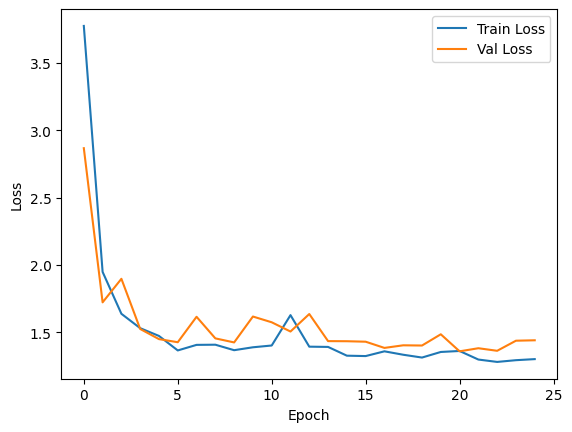

In [ ]:
# Parameters for the demo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_path = "/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/swin_transformer_model/rafdb_best_model.pth"

# Define the Swin Transformer model
model = Swin_S(num_classes=12000).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, val_losses = train_model(model, rafdb_train_loader, rafdb_val_loader, criterion, optimizer, num_epochs=num_epochs, device=device, save_path=save_path)

# Plot the training and validation loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Load the best model weights
save_path = "/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/swin_transformer_model/rafdb_best_model.pth"
best_model = Swin_S(num_classes=12000).to(device)
best_model.load_state_dict(torch.load(save_path))

# Calculate accuracy
val_accuracy = calculate_accuracy(best_model, rafdb_val_loader, device=device)
print(f'Validation Accuracy: {val_accuracy}')

Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.008696
Block Initial Type: W, drop_path_rate:0.017391
Block Initial Type: SW, drop_path_rate:0.026087
Block Initial Type: W, drop_path_rate:0.034783
Block Initial Type: SW, drop_path_rate:0.043478
Block Initial Type: W, drop_path_rate:0.052174
Block Initial Type: SW, drop_path_rate:0.060870
Block Initial Type: W, drop_path_rate:0.069565
Block Initial Type: SW, drop_path_rate:0.078261
Block Initial Type: W, drop_path_rate:0.086957
Block Initial Type: SW, drop_path_rate:0.095652
Block Initial Type: W, drop_path_rate:0.104348
Block Initial Type: SW, drop_path_rate:0.113043
Block Initial Type: W, drop_path_rate:0.121739
Block Initial Type: SW, drop_path_rate:0.130435
Block Initial Type: W, drop_path_rate:0.139130
Block Initial Type: SW, drop_path_rate:0.147826
Block Initial Type: W, drop_path_rate:0.156522
Block Initial Type: SW, drop_path_rate:0.165217
Block Initial Type: W, drop_path_rate:0.173913
Blo

#CK+ dataset train

In [12]:
class CKPlusDataset(Dataset):
    def __init__(self, csv_file, transform=None, usage='Training'):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.data = self.data[self.data['Usage'] == usage]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels'].split(' ')
        pixels = [float(p) for p in pixels]
        pixels = np.array(pixels, dtype=np.uint8).reshape(48, 48, 1)
        pixels = np.concatenate([pixels] * 3, axis=2)
        emotion = float(self.data.iloc[idx]['emotion'])
        pixels = pixels / 255.0
        if self.transform:
            pixels = self.transform(pixels)
        return pixels, emotion

train_dataset = CKPlusDataset(csv_file='/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/Dataset/CK+/ck+.csv', transform=ToTensor(), usage='Training')
val_dataset = CKPlusDataset(csv_file='/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/Dataset/CK+/ck+.csv', transform=ToTensor(), usage='PublicTest')

batch_size = 32
num_epochs = 25
learning_rate = 0.01
ck_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
ck_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [1]:
# Parameters for the demo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_path = "/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/swin_transformer_model/ck+_best_model.pth"

# Define the Swin Transformer model
model = Swin_S(num_classes=734).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, val_losses = train_model(model, ck_train_loader, ck_val_loader, criterion, optimizer, num_epochs=num_epochs, device=device, save_path=save_path)

# Plot the training and validation loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'torch' is not defined

In [ ]:
# Load the best model weights
save_path = "/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/swin_transformer_model/ck+_best_model.pth"
best_model = Swin_T(num_classes=734).to(device)
best_model.load_state_dict(torch.load(save_path))

# Calculate accuracy
val_accuracy = calculate_accuracy(best_model, ck_val_loader, device=device)
print(f'Validation Accuracy: {val_accuracy}')

Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.018182
Block Initial Type: W, drop_path_rate:0.036364
Block Initial Type: SW, drop_path_rate:0.054545
Block Initial Type: W, drop_path_rate:0.072727
Block Initial Type: SW, drop_path_rate:0.090909
Block Initial Type: W, drop_path_rate:0.109091
Block Initial Type: SW, drop_path_rate:0.127273
Block Initial Type: W, drop_path_rate:0.145455
Block Initial Type: SW, drop_path_rate:0.163636
Block Initial Type: W, drop_path_rate:0.181818
Block Initial Type: W, drop_path_rate:0.200000


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/swin_transformer_model/ck+_best_model.pth'

# FER2013 dataset train

In [ ]:
class fer2013Dataset(Dataset):
    def __init__(self, csv_file, transform=None, usage='Training'):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.data = self.data[self.data['Usage'] == usage]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels'].split(' ')
        pixels = [float(p) for p in pixels]
        pixels = np.array(pixels, dtype=np.uint8).reshape(48, 48, 1)  # Reshape pixels to image size
        emotion = float(self.data.iloc[idx]['emotion'])
        pixels = pixels / 255.0
        if self.transform:
            pixels = self.transform(pixels)
        return pixels, emotion

# Load dataset and split into train/validation sets
train_dataset = CKPlusDataset(csv_file='/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/Dataset/FER2013/fer2013/fer2013 short.csv', transform=ToTensor(), usage='Training')
val_dataset = CKPlusDataset(csv_file='/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/Dataset/FER2013/fer2013/fer2013 short.csv', transform=ToTensor(), usage='PublicTest')

# Define data loaders
batch_size = 32
num_epochs = 25
learning_rate = 0.01
fer_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
fer_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Parameters for the demo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_path = "/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/swin_transformer_model/fer2013_best_model.pth"

# Define the Swin Transformer model
model = Swin_S(num_classes=500).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, val_losses = train_model(model, fer_train_loader, fer_val_loader, criterion, optimizer, num_epochs=num_epochs, device=device, save_path=save_path)

# Plot the training and validation loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.008696
Block Initial Type: W, drop_path_rate:0.017391
Block Initial Type: SW, drop_path_rate:0.026087
Block Initial Type: W, drop_path_rate:0.034783
Block Initial Type: SW, drop_path_rate:0.043478
Block Initial Type: W, drop_path_rate:0.052174
Block Initial Type: SW, drop_path_rate:0.060870
Block Initial Type: W, drop_path_rate:0.069565
Block Initial Type: SW, drop_path_rate:0.078261
Block Initial Type: W, drop_path_rate:0.086957
Block Initial Type: SW, drop_path_rate:0.095652
Block Initial Type: W, drop_path_rate:0.104348
Block Initial Type: SW, drop_path_rate:0.113043
Block Initial Type: W, drop_path_rate:0.121739
Block Initial Type: SW, drop_path_rate:0.130435
Block Initial Type: W, drop_path_rate:0.139130
Block Initial Type: SW, drop_path_rate:0.147826
Block Initial Type: W, drop_path_rate:0.156522
Block Initial Type: SW, drop_path_rate:0.165217
Block Initial Type: W, drop_path_rate:0.173913
Blo

RuntimeError: Given groups=1, weight of size [96, 3, 4, 4], expected input[32, 1, 48, 48] to have 3 channels, but got 1 channels instead

In [ ]:
# Load the best model weights
save_path = "/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/swin_transformer_model/fer2013 short_best_model.pth"
best_model = Swin_T(num_classes=500).to(device)
best_model.load_state_dict(torch.load(save_path))

# Calculate accuracy
val_accuracy = calculate_accuracy(best_model, fer_val_loader, device=device)
print(f'Validation Accuracy: {val_accuracy}')

Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.018182
Block Initial Type: W, drop_path_rate:0.036364
Block Initial Type: SW, drop_path_rate:0.054545
Block Initial Type: W, drop_path_rate:0.072727
Block Initial Type: SW, drop_path_rate:0.090909
Block Initial Type: W, drop_path_rate:0.109091
Block Initial Type: SW, drop_path_rate:0.127273
Block Initial Type: W, drop_path_rate:0.145455
Block Initial Type: SW, drop_path_rate:0.163636
Block Initial Type: W, drop_path_rate:0.181818
Block Initial Type: W, drop_path_rate:0.200000


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Content Recommendation System based on Facial expression recognition using Swin Transformer and Haar Cascade/swin_transformer_model/ck+_best_model.pth'